$$ d_e(x,y) = \sqrt{\displaystyle\sum_{i=1} ^{n} (y_i - x_i)^2} $$

$$\hat{f}(\xi) = \int_{-\infty} ^{\infty}f(x) e^{-i2\pi\xi x}dx.$$

$$d_{RBF_k}(x,y) = e^{-\frac{||x - y||^2}{2\sigma^2}}

$$ \frac{\partial d}{\partial p} $$

$$s_p = \log\left(\frac{1}{n} \sum \frac{\Delta d_n}{\Delta p_n}\right) $$

$$
\left.
    \begin{array}{ll}
        \pm 1 \% \\
        \pm 0.1 \% \\
        \pm 0.02 \% 
    \end{array}
    \right\}
$$

In [24]:
#Create images of sensitivity analysis
import numpy as np
from tabulate import tabulate
import matplotlib.pyplot as plt
from scipy.integrate import odeint


#Distance function
def euclidean_distance_multiple_trajectories(observed_trajectories, simulated_trajectories):
    num_trajectories = len(observed_trajectories)
    total_distance = 0.0

    for i in range(num_trajectories):
        observed_data = observed_trajectories[i]
        simulated_data = simulated_trajectories[i]

        # Calculate the Euclidean distance between observed and simulated data
        euclidean_distance = np.linalg.norm(observed_data - simulated_data)

        # Accumulate the distances
        total_distance += euclidean_distance

    # Average the distances over all trajectories
    average_distance = total_distance / num_trajectories

    return average_distance


def model(variables, t, params):
    m1, p1, m2, p2, m3, p3 = variables
    k1, a1, b1, n1, gamma1, k2, a2, b2, n2, gamma2, k3, a3, b3, n3, gamma3 = params

    dm1dt = -m1 + (10 ** a1 / (1 + (10 ** k1 * p2) ** n1)) + 10 ** gamma1
    dp1dt = -10 ** b1 * (p1 - m1)

    dm2dt = -m2 + (10 ** a2 / (1 + (10 ** k2 * p3) ** n2)) + 10 ** gamma2
    dp2dt = -10 ** b2 * (p2 - m2)

    dm3dt = -m3 + (10 ** a3 / (1 + (10 ** k3 * p1) ** n3)) + 10 ** gamma3
    dp3dt = -10 ** b3 * (p3 - m3)

    return [dm1dt, dp1dt, dm2dt, dp2dt, dm3dt, dp3dt]

true_params = np.array([
    0, 3, 0, 2, 0,  # first set of odes
    0, 3, 0, 2, 0, # second set of odes
    0, 3, 0, 2, 0  # third set of odes
])

def solve_ode(params, t):
    initial_conditions = np.array([0, 1, 0, 3, 0, 2])
    solution = odeint(model, initial_conditions, t, args=(params,))
    return solution

num_timesteps = 10  # Number of time steps for simulation
t = np.linspace(0, 100, num_timesteps)
true_data = solve_ode(true_params, t)

#To get index of the minimum D:
def min_val_ind(arr_y):
    target_value = min(arr_y)
    indices = np.where(arr_y == target_value)[0]
    
    if indices.size > 0:
        return indices

#The only thing we need to change is where the parameter is in param space! And distance function if we want!

def plots_sensitivity():
    datapoints = 1000 # How many steps in parameter space we have taken
    global p_seq
    global D_p
    global dDdp
    p_seq = np.linspace(-1, 1, datapoints) #All ks behave the same
    D_p = []
    p_collect = []
    for i in range(np.size(p_seq)):
        ########################################
        p_params = np.array([p_seq[i], 3, 0, 2, 0, 
                             0, 3, 0, 2, 0, 
                             0, 3, 0, 2, 0]) #Need to change this! In this case k1
        ########################################
        p_collect.append(p_params)
        data_p = solve_ode(p_params, t)
        dist = euclidean_distance_multiple_trajectories(true_data, data_p) #Can also change the distance function
        D_p.append(dist)

    step_size = np.array([10,100,500]) #Steps to take right and left, the higher the number, the closer to the true value

    #To get indices we sample:
    indices_array = []
    for i in step_size:
        indices_array.append(np.array([datapoints//i, -datapoints//i])) #How many steps do we record?

    #To get the ks that correspond to the indices we sample, and create useful arrays:
    min_ind = int(min_val_ind(D_p))
    global lowestD_p
    lowestD_p = p_seq[min_ind]
    global lowestD
    lowestD = D_p[min_ind]
    p_array = np.array([p_seq, D_p])
    grad = np.gradient(p_array) #Could also do np.diff, same result
    array_p_eval = []
    array_D_eval = []
    dD_array = []
    for i in indices_array:
        upperp = min_ind + i[0]
        lowerp = min_ind - i[0]
        array_p_eval.append(np.array([p_seq[int(upperp)], p_seq[int(lowerp)]])) #Save parameters
        array_D_eval.append(np.array([D_p[int(upperp)], D_p[int(lowerp)]])) #Same for distance
        dD_array.append(np.array([grad[1][1][int(upperp)], grad[1][1][int(lowerp)]])) #Same for derivative

    dDdp = grad[1][1]
    fig, axs = plt.subplots(1, 2, figsize=(12, 8))
    axs = axs.flatten()
    axs[0].plot(p_seq, D_p)
    axs[0].set_ylabel("Euclidean distance")
    axs[0].set_xlabel("p")
    axs[1].plot(p_seq, grad[1][1])
    axs[1].set_ylabel("dD/dp")
    axs[1].set_xlabel("p")

    return p_seq, D_p, dDdp, array_p_eval, array_D_eval #It returns where it is being evaluated!

def calc_sens_metric(array_p_eval, array_D_eval): #Try with log10
    p_raw = []
    D_raw = []
    for i in array_p_eval:  # Get raw arrays for metric calculation
        p_raw.append(i[0])
        p_raw.append(i[1])
    for i in array_D_eval:  # Get raw arrays for metric calculation
        D_raw.append(i[0])
        D_raw.append(i[1])
    deltaD = []
    deltap = []
    for p in p_raw:
        deltap.append(np.abs(p) - np.abs(lowestD_p))
    for D in D_raw:
        deltaD.append(np.abs(D) - np.abs(lowestD))
    metric = []
    for i in range(len(deltaD)):
        metric.append(np.abs(deltaD[i]) / np.abs(deltap[i]))
    result_sense = np.log(np.mean(metric))
    return result_sense

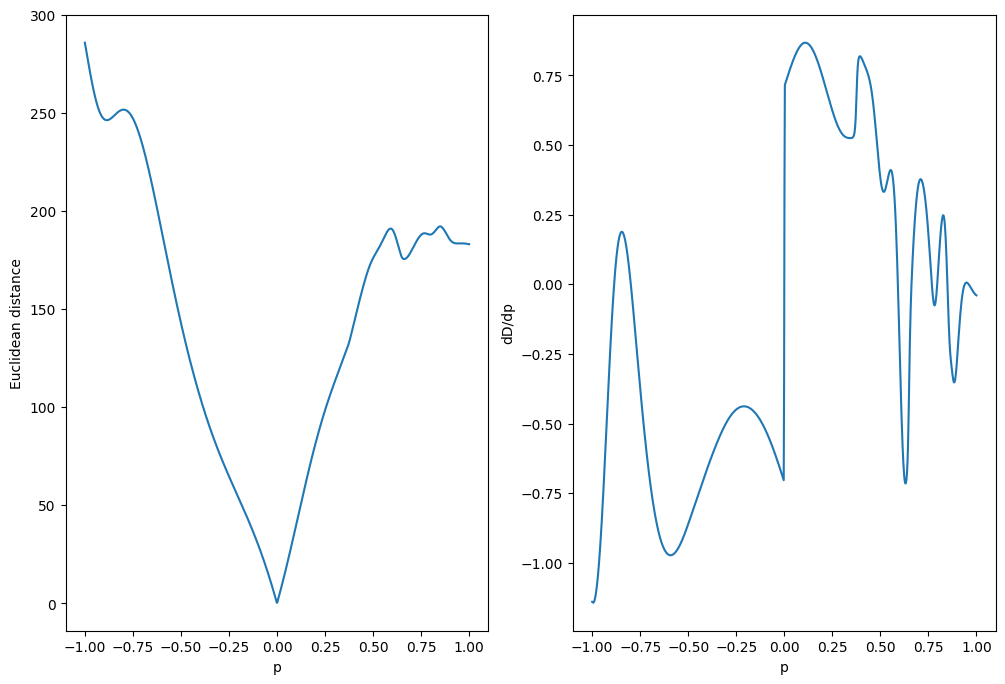

In [25]:
k_seq, D_k, dDdk, array_p_eval_k, array_D_eval_k = plots_sensitivity()

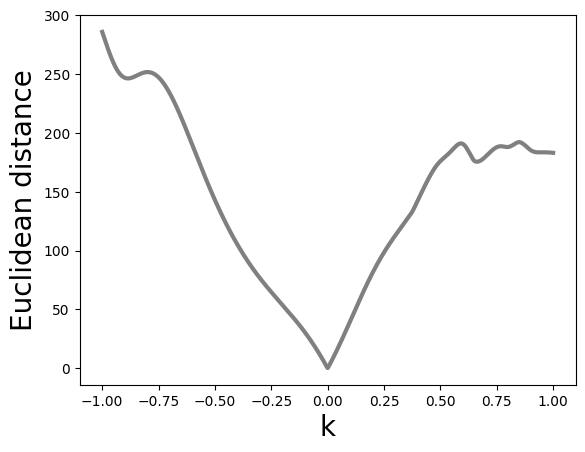

In [6]:
fig, ax = plt.subplots() 
ax.plot(k_seq, D_k, color = "grey", linewidth = 3) 
ax.set_xlabel('k', fontsize = 20) 
ax.set_ylabel('Euclidean distance', fontsize = 20) 
  
plt.show()


In [7]:
# Get the broad plot wide priors
#Create images of sensitivity analysis
import numpy as np
from tabulate import tabulate
import matplotlib.pyplot as plt
from scipy.integrate import odeint


#Distance function
def euclidean_distance_multiple_trajectories(observed_trajectories, simulated_trajectories):
    num_trajectories = len(observed_trajectories)
    total_distance = 0.0

    for i in range(num_trajectories):
        observed_data = observed_trajectories[i]
        simulated_data = simulated_trajectories[i]

        # Calculate the Euclidean distance between observed and simulated data
        euclidean_distance = np.linalg.norm(observed_data - simulated_data)

        # Accumulate the distances
        total_distance += euclidean_distance

    # Average the distances over all trajectories
    average_distance = total_distance / num_trajectories

    return average_distance


def model(variables, t, params):
    m1, p1, m2, p2, m3, p3 = variables
    k1, a1, b1, n1, gamma1, k2, a2, b2, n2, gamma2, k3, a3, b3, n3, gamma3 = params

    dm1dt = -m1 + (10 ** a1 / (1 + (10 ** k1 * p2) ** n1)) + 10 ** gamma1
    dp1dt = -10 ** b1 * (p1 - m1)

    dm2dt = -m2 + (10 ** a2 / (1 + (10 ** k2 * p3) ** n2)) + 10 ** gamma2
    dp2dt = -10 ** b2 * (p2 - m2)

    dm3dt = -m3 + (10 ** a3 / (1 + (10 ** k3 * p1) ** n3)) + 10 ** gamma3
    dp3dt = -10 ** b3 * (p3 - m3)

    return [dm1dt, dp1dt, dm2dt, dp2dt, dm3dt, dp3dt]

true_params = np.array([
    0, 3, 0, 2, 0,  # first set of odes
    0, 3, 0, 2, 0, # second set of odes
    0, 3, 0, 2, 0  # third set of odes
])

def solve_ode(params, t):
    initial_conditions = np.array([0, 1, 0, 3, 0, 2])
    solution = odeint(model, initial_conditions, t, args=(params,))
    return solution

num_timesteps = 10  # Number of time steps for simulation
t = np.linspace(0, 100, num_timesteps)
true_data = solve_ode(true_params, t)

#To get index of the minimum D:
def min_val_ind(arr_y):
    target_value = min(arr_y)
    indices = np.where(arr_y == target_value)[0]
    
    if indices.size > 0:
        return indices

#The only thing we need to change is where the parameter is in param space! And distance function if we want!

def plots_sensitivity():
    datapoints = 1000 # How many steps in parameter space we have taken
    global p_seq
    global D_p
    global dDdp
    p_seq = np.linspace(-4, 4, datapoints) #All ks behave the same
    D_p = []
    p_collect = []
    for i in range(np.size(p_seq)):
        ########################################
        p_params = np.array([p_seq[i], 3, 0, 2, 0, 
                             0, 3, 0, 2, 0, 
                             0, 3, 0, 2, 0]) #Need to change this! In this case k1
        ########################################
        p_collect.append(p_params)
        data_p = solve_ode(p_params, t)
        dist = euclidean_distance_multiple_trajectories(true_data, data_p) #Can also change the distance function
        D_p.append(dist)

    step_size = np.array([10,100,500]) #Steps to take right and left, the higher the number, the closer to the true value

    #To get indices we sample:
    indices_array = []
    for i in step_size:
        indices_array.append(np.array([datapoints//i, -datapoints//i])) #How many steps do we record?

    #To get the ks that correspond to the indices we sample, and create useful arrays:
    min_ind = int(min_val_ind(D_p))
    global lowestD_p
    lowestD_p = p_seq[min_ind]
    global lowestD
    lowestD = D_p[min_ind]
    p_array = np.array([p_seq, D_p])
    grad = np.gradient(p_array) #Could also do np.diff, same result
    array_p_eval = []
    array_D_eval = []
    dD_array = []
    for i in indices_array:
        upperp = min_ind + i[0]
        lowerp = min_ind - i[0]
        array_p_eval.append(np.array([p_seq[int(upperp)], p_seq[int(lowerp)]])) #Save parameters
        array_D_eval.append(np.array([D_p[int(upperp)], D_p[int(lowerp)]])) #Same for distance
        dD_array.append(np.array([grad[1][1][int(upperp)], grad[1][1][int(lowerp)]])) #Same for derivative

    dDdp = grad[1][1]
    fig, axs = plt.subplots(1, 2, figsize=(12, 8))
    axs = axs.flatten()
    axs[0].plot(p_seq, D_p)
    axs[0].set_ylabel("Euclidean distance")
    axs[0].set_xlabel("p")
    axs[1].plot(p_seq, grad[1][1])
    axs[1].set_ylabel("dD/dp")
    axs[1].set_xlabel("p")

    return p_seq, D_p, dDdp, array_p_eval, array_D_eval #It returns where it is being evaluated!

def calc_sens_metric(array_p_eval, array_D_eval): #Try with log10
    p_raw = []
    D_raw = []
    for i in array_p_eval:  # Get raw arrays for metric calculation
        p_raw.append(i[0])
        p_raw.append(i[1])
    for i in array_D_eval:  # Get raw arrays for metric calculation
        D_raw.append(i[0])
        D_raw.append(i[1])
    deltaD = []
    deltap = []
    for p in p_raw:
        deltap.append(np.abs(p) - np.abs(lowestD_p))
    for D in D_raw:
        deltaD.append(np.abs(D) - np.abs(lowestD))
    metric = []
    for i in range(len(deltaD)):
        metric.append(np.abs(deltaD[i]) / np.abs(deltap[i]))
    result_sense = np.log(np.mean(metric))
    return result_sense

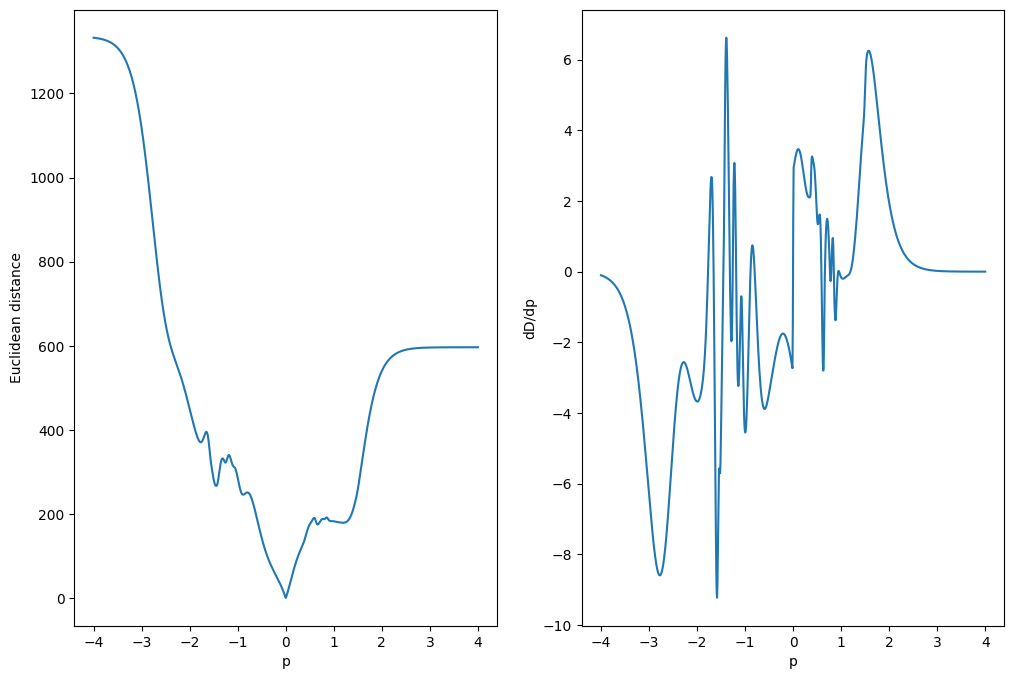

In [8]:
k_seq, D_k, dDdk, array_p_eval_k, array_D_eval_k = plots_sensitivity()

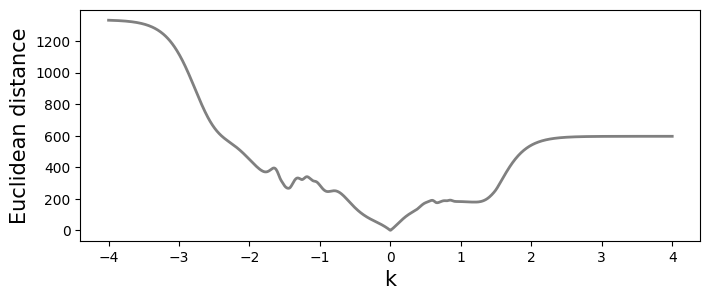

In [16]:
fig, ax = plt.subplots(figsize=(8,3)) 
ax.plot(k_seq, D_k, color = "grey", linewidth = 2) 
ax.set_xlabel('k', fontsize = 15) 
ax.set_ylabel('Euclidean distance', fontsize = 15) 
  
plt.show()


In [26]:
#beta
import numpy as np
from tabulate import tabulate
import matplotlib.pyplot as plt
from scipy.integrate import odeint
def model(variables, t, params):
    m1, p1, m2, p2, m3, p3 = variables
    k1, a1, b1, n1, gamma1, k2, a2, b2, n2, gamma2, k3, a3, b3, n3, gamma3 = params

    dm1dt = -m1 + (10 ** a1 / (1 + (10 ** k1 * p2) ** n1)) + 10 ** gamma1
    dp1dt = -10 ** b1 * (p1 - m1)

    dm2dt = -m2 + (10 ** a2 / (1 + (10 ** k2 * p3) ** n2)) + 10 ** gamma2
    dp2dt = -10 ** b2 * (p2 - m2)

    dm3dt = -m3 + (10 ** a3 / (1 + (10 ** k3 * p1) ** n3)) + 10 ** gamma3
    dp3dt = -10 ** b3 * (p3 - m3)

    return [dm1dt, dp1dt, dm2dt, dp2dt, dm3dt, dp3dt]

true_params = np.array([
    0, 3, 0, 2, 0,  # first set of odes
    0, 3, 0, 2, 0, # second set of odes
    0, 3, 0, 2, 0  # third set of odes
])

def solve_ode(params, t):
    initial_conditions = np.array([0, 1, 0, 3, 0, 2])
    solution = odeint(model, initial_conditions, t, args=(params,))
    return solution

num_timesteps = 10  # Number of time steps for simulation
t = np.linspace(0, 100, num_timesteps)
true_data = solve_ode(true_params, t)

#To get index of the minimum D:
def min_val_ind(arr_y):
    target_value = min(arr_y)
    indices = np.where(arr_y == target_value)[0]
    
    if indices.size > 0:
        return indices

#The only thing we need to change is where the parameter is in param space! And distance function if we want!

def plots_sensitivity():
    datapoints = 1000 # How many steps in parameter space we have taken
    global p_seq
    global D_p
    global dDdp
    p_seq = np.linspace(-1, 1, datapoints) #All ks behave the same
    D_p = []
    p_collect = []
    for i in range(np.size(p_seq)):
        ########################################
        p_params = np.array([0, 3, p_seq[i], 2, 0, 
                             0, 3, 0, 2, 0, 
                             0, 3, 0, 2, 0]) #Need to change this! In this case k1
        ########################################
        p_collect.append(p_params)
        data_p = solve_ode(p_params, t)
        dist = euclidean_distance_multiple_trajectories(true_data, data_p) #Can also change the distance function
        D_p.append(dist)

    step_size = np.array([10,100,500]) #Steps to take right and left, the higher the number, the closer to the true value

    #To get indices we sample:
    indices_array = []
    for i in step_size:
        indices_array.append(np.array([datapoints//i, -datapoints//i])) #How many steps do we record?

    #To get the ks that correspond to the indices we sample, and create useful arrays:
    min_ind = int(min_val_ind(D_p))
    global lowestD_p
    lowestD_p = p_seq[min_ind]
    global lowestD
    lowestD = D_p[min_ind]
    p_array = np.array([p_seq, D_p])
    grad = np.gradient(p_array) #Could also do np.diff, same result
    array_p_eval = []
    array_D_eval = []
    dD_array = []
    for i in indices_array:
        upperp = min_ind + i[0]
        lowerp = min_ind - i[0]
        array_p_eval.append(np.array([p_seq[int(upperp)], p_seq[int(lowerp)]])) #Save parameters
        array_D_eval.append(np.array([D_p[int(upperp)], D_p[int(lowerp)]])) #Same for distance
        dD_array.append(np.array([grad[1][1][int(upperp)], grad[1][1][int(lowerp)]])) #Same for derivative

    dDdp = grad[1][1]
    fig, axs = plt.subplots(1, 2, figsize=(12, 8))
    axs = axs.flatten()
    axs[0].plot(p_seq, D_p)
    axs[0].set_ylabel("Euclidean distance")
    axs[0].set_xlabel("p")
    axs[1].plot(p_seq, grad[1][1])
    axs[1].set_ylabel("dD/dp")
    axs[1].set_xlabel("p")

    return p_seq, D_p, dDdp, array_p_eval, array_D_eval #It returns where it is being evaluated!

def calc_sens_metric(array_p_eval, array_D_eval):
    p_raw = []
    D_raw = []
    for i in array_p_eval:  # Get raw arrays for metric calculation
        p_raw.append(i[0])
        p_raw.append(i[1])
    for i in array_D_eval:  # Get raw arrays for metric calculation
        D_raw.append(i[0])
        D_raw.append(i[1])
    deltaD = []
    deltap = []
    for p in p_raw:
        deltap.append(np.abs(p) - np.abs(lowestD_p))
    for D in D_raw:
        deltaD.append(np.abs(D) - np.abs(lowestD))
    metric = []
    for i in range(len(deltaD)):
        metric.append(np.abs(deltaD[i]) / np.abs(deltap[i]))
    result_sense = np.log(np.mean(metric))
    return result_sense

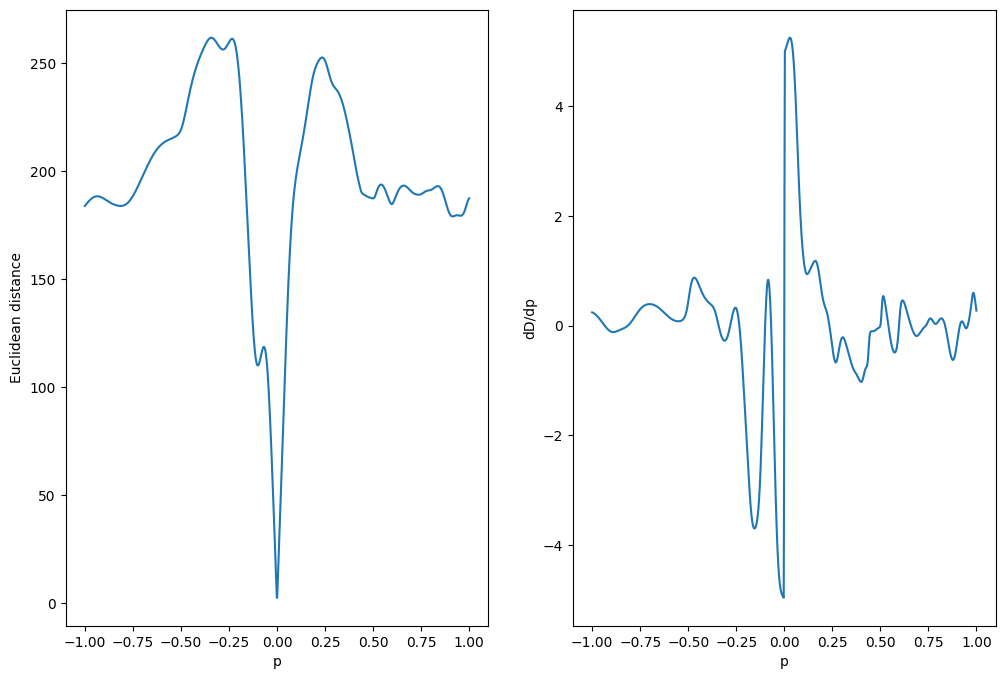

In [27]:
b_seq, D_b, dDdb, array_p_eval_b, array_D_eval_b = plots_sensitivity()

In [33]:
#Do for gamma
#beta
import numpy as np
from tabulate import tabulate
import matplotlib.pyplot as plt
from scipy.integrate import odeint
def model(variables, t, params):
    m1, p1, m2, p2, m3, p3 = variables
    k1, a1, b1, n1, gamma1, k2, a2, b2, n2, gamma2, k3, a3, b3, n3, gamma3 = params

    dm1dt = -m1 + (10 ** a1 / (1 + (10 ** k1 * p2) ** n1)) + 10 ** gamma1
    dp1dt = -10 ** b1 * (p1 - m1)

    dm2dt = -m2 + (10 ** a2 / (1 + (10 ** k2 * p3) ** n2)) + 10 ** gamma2
    dp2dt = -10 ** b2 * (p2 - m2)

    dm3dt = -m3 + (10 ** a3 / (1 + (10 ** k3 * p1) ** n3)) + 10 ** gamma3
    dp3dt = -10 ** b3 * (p3 - m3)

    return [dm1dt, dp1dt, dm2dt, dp2dt, dm3dt, dp3dt]

true_params = np.array([
    0, 3, 0, 2, 0,  # first set of odes
    0, 3, 0, 2, 0, # second set of odes
    0, 3, 0, 2, 0  # third set of odes
])

def solve_ode(params, t):
    initial_conditions = np.array([0, 1, 0, 3, 0, 2])
    solution = odeint(model, initial_conditions, t, args=(params,))
    return solution

num_timesteps = 10  # Number of time steps for simulation
t = np.linspace(0, 100, num_timesteps)
true_data = solve_ode(true_params, t)

#To get index of the minimum D:
def min_val_ind(arr_y):
    target_value = min(arr_y)
    indices = np.where(arr_y == target_value)[0]
    
    if indices.size > 0:
        return indices

#The only thing we need to change is where the parameter is in param space! And distance function if we want!

def plots_sensitivity():
    datapoints = 1000 # How many steps in parameter space we have taken
    global p_seq
    global D_p
    global dDdp
    p_seq = np.linspace(-1, 1, datapoints) #All ks behave the same
    D_p = []
    p_collect = []
    for i in range(np.size(p_seq)):
        ########################################
        p_params = np.array([0, 3, 0, 2, p_seq[i], 
                             0, 3, 0, 2, 0, 
                             0, 3, 0, 2, 0]) #Need to change this! In this case k1
        ########################################
        p_collect.append(p_params)
        data_p = solve_ode(p_params, t)
        dist = euclidean_distance_multiple_trajectories(true_data, data_p) #Can also change the distance function
        D_p.append(dist)

    step_size = np.array([10,100,500]) #Steps to take right and left, the higher the number, the closer to the true value

    #To get indices we sample:
    indices_array = []
    for i in step_size:
        indices_array.append(np.array([datapoints//i, -datapoints//i])) #How many steps do we record?

    #To get the ks that correspond to the indices we sample, and create useful arrays:
    min_ind = int(min_val_ind(D_p))
    global lowestD_p
    lowestD_p = p_seq[min_ind]
    global lowestD
    lowestD = D_p[min_ind]
    p_array = np.array([p_seq, D_p])
    grad = np.gradient(p_array) #Could also do np.diff, same result
    array_p_eval = []
    array_D_eval = []
    dD_array = []
    for i in indices_array:
        upperp = min_ind + i[0]
        lowerp = min_ind - i[0]
        array_p_eval.append(np.array([p_seq[int(upperp)], p_seq[int(lowerp)]])) #Save parameters
        array_D_eval.append(np.array([D_p[int(upperp)], D_p[int(lowerp)]])) #Same for distance
        dD_array.append(np.array([grad[1][1][int(upperp)], grad[1][1][int(lowerp)]])) #Same for derivative

    dDdp = grad[1][1]
    fig, axs = plt.subplots(1, 2, figsize=(12, 8))
    axs = axs.flatten()
    axs[0].plot(p_seq, D_p)
    axs[0].set_ylabel("Euclidean distance")
    axs[0].set_xlabel("p")
    axs[1].plot(p_seq, grad[1][1])
    axs[1].set_ylabel("dD/dp")
    axs[1].set_xlabel("p")

    return p_seq, D_p, dDdp, array_p_eval, array_D_eval #It returns where it is being evaluated!

def calc_sens_metric(array_p_eval, array_D_eval):
    p_raw = []
    D_raw = []
    for i in array_p_eval:  # Get raw arrays for metric calculation
        p_raw.append(i[0])
        p_raw.append(i[1])
    for i in array_D_eval:  # Get raw arrays for metric calculation
        D_raw.append(i[0])
        D_raw.append(i[1])
    deltaD = []
    deltap = []
    for p in p_raw:
        deltap.append(np.abs(p) - np.abs(lowestD_p))
    for D in D_raw:
        deltaD.append(np.abs(D) - np.abs(lowestD))
    metric = []
    for i in range(len(deltaD)):
        metric.append(np.abs(deltaD[i]) / np.abs(deltap[i]))
    result_sense = np.log(np.mean(metric))
    return result_sense

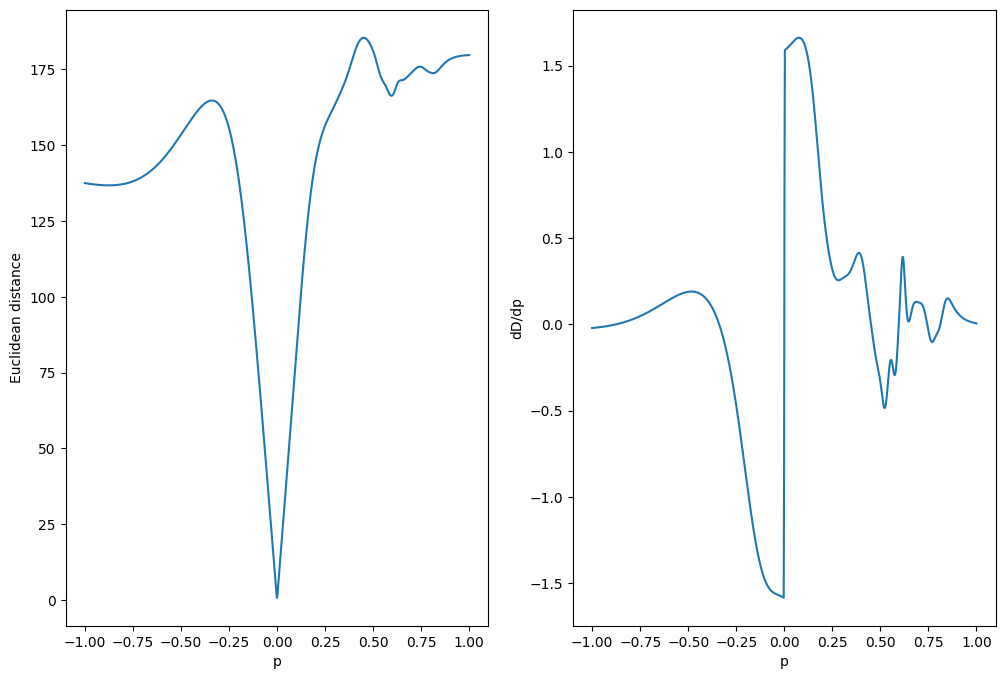

In [34]:
g_seq, D_g, dDdg, array_p_eval_g, array_D_eval_g = plots_sensitivity()

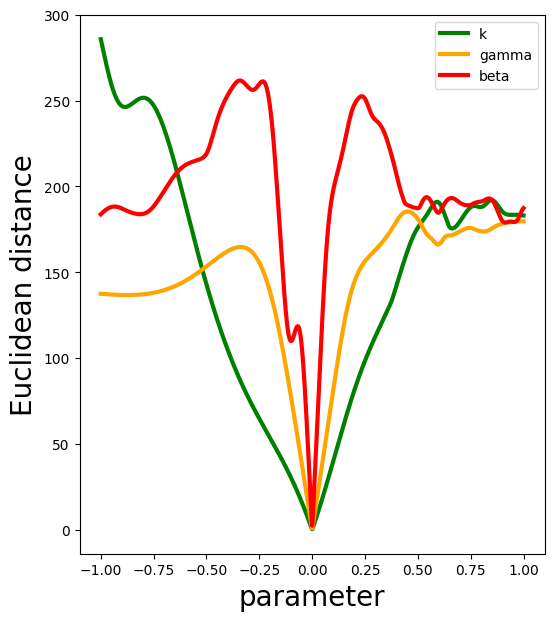

In [41]:
fig, ax = plt.subplots(figsize=(6,7))
ax.plot(k_seq, D_k, color = "green", label = "k", linewidth = 3) 
ax.plot(g_seq, D_g, color = "orange", label = "gamma", linewidth = 3) 
ax.plot(b_seq, D_b, color = "red", label = "beta", linewidth = 3) 
ax.set_xlabel('parameter', fontsize = 20) 
ax.set_ylabel('Euclidean distance', fontsize = 20) 
plt.legend()
plt.show()